# TalkingData Fraud Click Prediction

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

from sklearn.metrics import roc_curve,roc_auc_score
from sklearn.model_selection import train_test_split
from catboost import Pool, CatBoostClassifier, CatBoost
from tqdm import tqdm

## Load Train & Test data

### Check data format

In [3]:
train_df = pd.read_csv('../data/train.csv').sort_values('click_time')
train_df

,ip,app,device,os,channel,click_time,attributed_time,is_attributed
0,83230,3,1,13,379,2017-11-06 14:32:21,NaN,0
1,17357,3,1,19,379,2017-11-06 14:33:34,NaN,0
2,35810,3,1,13,379,2017-11-06 14:34:12,NaN,0
3,45745,14,1,13,478,2017-11-06 14:34:52,NaN,0
4,161007,3,1,13,379,2017-11-06 14:35:08,NaN,0
...,...,...,...,...,...,...,...,...
184903585,85836,9,1,32,466,2017-11-09 16:00:00,NaN,0
184903584,320126,8,1,13,145,2017-11-09 16:00:00,NaN,0
184903583,25614,2,1,19,205,2017-11-09 16:00:00,NaN,0
184903665,92190,9,1,23,127,2017-11-09 16:00:00,NaN,0


In [4]:
train_df.describe()

,ip,app,device,os,channel,is_attributed
count,1.849039e+08,1.849039e+08,1.849039e+08,1.849039e+08,1.849039e+08,1.849039e+08
mean,9.087604e+04,1.201131e+01,2.172325e+01,2.267702e+01,2.685789e+02,2.470721e-03
std,6.952789e+04,1.480521e+01,2.593326e+02,5.525282e+01,1.295882e+02,4.964491e-02
min,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,4.024500e+04,3.000000e+00,1.000000e+00,1.300000e+01,1.400000e+02,0.000000e+00
50%,7.962200e+04,1.200000e+01,1.000000e+00,1.800000e+01,2.580000e+02,0.000000e+00
75%,1.182470e+05,1.500000e+01,1.000000e+00,1.900000e+01,3.790000e+02,0.000000e+00
max,3.647780e+05,7.680000e+02,4.227000e+03,9.560000e+02,5.000000e+02,1.000000e+00


In [5]:
test_df = pd.read_csv('../data/test.csv').sort_values('click_time')
test_df

,click_id,ip,app,device,os,channel,click_time
0,0,5744,9,1,3,107,2017-11-10 04:00:00
284,285,115292,12,1,22,424,2017-11-10 04:00:00
283,283,39090,9,1,23,127,2017-11-10 04:00:00
282,281,72175,9,1,19,127,2017-11-10 04:00:00
281,280,125580,3,1,19,137,2017-11-10 04:00:00
...,...,...,...,...,...,...,...
18790128,18790128,84816,1,2,13,134,2017-11-10 15:00:00
18790127,18790127,95003,27,1,19,153,2017-11-10 15:00:00
18790126,18790126,45965,12,1,16,178,2017-11-10 15:00:00
18790139,18790139,14598,12,1,23,259,2017-11-10 15:00:00


In [6]:
test_df.describe()

,click_id,ip,app,device,os,channel
count,1.879047e+07,1.879047e+07,1.879047e+07,1.879047e+07,1.879047e+07,1.879047e+07
mean,9.395234e+06,6.306921e+04,1.221480e+01,1.730513e+00,1.873312e+01,2.648059e+02
std,5.424341e+06,3.688597e+04,1.164924e+01,2.597038e+01,1.135059e+01,1.355254e+02
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,4.697617e+06,3.155800e+04,3.000000e+00,1.000000e+00,1.300000e+01,1.350000e+02
50%,9.395234e+06,6.393600e+04,1.200000e+01,1.000000e+00,1.800000e+01,2.360000e+02
75%,1.409285e+07,9.531600e+04,1.800000e+01,1.000000e+00,1.900000e+01,4.010000e+02
max,1.879047e+07,1.264130e+05,5.210000e+02,3.031000e+03,6.040000e+02,4.980000e+02


### Load data correctly to reduce memory footprint

In [2]:
data_types = {
        'ip'            : 'uint32',
        'app'           : 'uint16',
        'device'        : 'uint16',
        'os'            : 'uint16',
        'channel'       : 'uint16',
        'is_attributed' : 'uint8',
        'click_id'      : 'uint32'
        }
train_df = pd.read_csv('../data/train.csv', dtype=data_types, parse_dates=['click_time']).drop('attributed_time', axis=1).sort_values('click_time')
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 184903890 entries, 0 to 184903889
Data columns (total 7 columns):
 #   Column         Dtype         
---  ------         -----         
 0   ip             uint32        
 1   app            uint16        
 2   device         uint16        
 3   os             uint16        
 4   channel        uint16        
 5   click_time     datetime64[ns]
 6   is_attributed  uint8         
dtypes: datetime64[ns](1), uint16(4), uint32(1), uint8(1)
memory usage: 5.0 GB


In [3]:
test_df = pd.read_csv('../data/test.csv', dtype=data_types, parse_dates=['click_time']).sort_values('click_time')
test_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18790469 entries, 0 to 18790468
Data columns (total 7 columns):
 #   Column      Dtype         
---  ------      -----         
 0   click_id    uint32        
 1   ip          uint32        
 2   app         uint16        
 3   device      uint16        
 4   os          uint16        
 5   channel     uint16        
 6   click_time  datetime64[ns]
dtypes: datetime64[ns](1), uint16(4), uint32(2)
memory usage: 573.4 MB


In [4]:
train_df.is_attributed.mean() # highly unbalanced classes

0.002470721410998979

## Baseline - CatBoost w/o feature engineering

In [5]:
for df in [train_df, test_df]:
    df['hour'] = df.click_time.dt.hour.astype('uint8')
    df['day'] = df.click_time.dt.day.astype('uint8')
    df['hour_of_month'] = (df.hour + df.day*24).astype('uint16')
cat_features = ['ip', 'app', 'device', 'os', 'channel', 'hour'] # All features in our dataset are categorical
num_features = []
target = 'is_attributed'

In [6]:
# To split our dataset ot train and val we need to simulate ~12h gap between train and test 

TRAIN_END = '2017-11-08 16:00:00'
VAL_START = '2017-11-09 04:00:00'
VAL_END = '2017-11-09 15:00:00'
train_filter = train_df.click_time < TRAIN_END
val_filter = (train_df.click_time > VAL_START) & (train_df.click_time < VAL_END)

train_pool = Pool(train_df[train_filter][cat_features+num_features], train_df[train_filter][target], feature_names=cat_features+num_features)
val_pool = Pool(train_df[val_filter][cat_features+num_features], train_df[val_filter][target], feature_names=cat_features+num_features)
train_filter.sum(), val_filter.sum()

(122070801, 37168192)

### Model Training

In [7]:
model = CatBoostClassifier(iterations=1000, depth=6, loss_function='Logloss', learning_rate=0.03,
                           eval_metric='AUC', random_seed=42, verbose=100, metric_period=10, task_type='GPU', scale_pos_weight=1./train_df.is_attributed.mean())
model.fit(train_pool, eval_set=val_pool, use_best_model=True)

0:	learn: 0.9192127	test: 0.9153981	best: 0.9153981 (0)	total: 813ms	remaining: 13m 32s
100:	learn: 0.9593359	test: 0.9525568	best: 0.9525568 (100)	total: 37.8s	remaining: 5m 36s
200:	learn: 0.9635992	test: 0.9562781	best: 0.9562781 (200)	total: 1m 14s	remaining: 4m 55s
300:	learn: 0.9657634	test: 0.9585456	best: 0.9585456 (300)	total: 1m 51s	remaining: 4m 18s
400:	learn: 0.9671679	test: 0.9600140	best: 0.9600140 (400)	total: 2m 28s	remaining: 3m 41s
500:	learn: 0.9680920	test: 0.9610261	best: 0.9610261 (500)	total: 3m 5s	remaining: 3m 4s
600:	learn: 0.9688171	test: 0.9617832	best: 0.9617832 (600)	total: 3m 42s	remaining: 2m 27s
700:	learn: 0.9693716	test: 0.9623159	best: 0.9623159 (700)	total: 4m 20s	remaining: 1m 50s
800:	learn: 0.9698319	test: 0.9627826	best: 0.9627826 (800)	total: 4m 57s	remaining: 1m 13s
900:	learn: 0.9702196	test: 0.9631729	best: 0.9631729 (900)	total: 5m 34s	remaining: 36.8s
999:	learn: 0.9705643	test: 0.9635219	best: 0.9635219 (999)	total: 6m 12s	remaining: 0us

### Feature importance

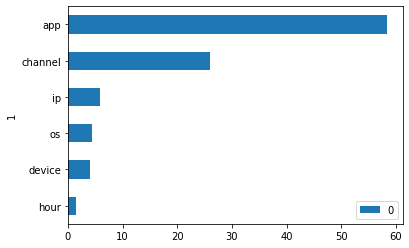

In [8]:
imp = pd.DataFrame(list(zip(model.get_feature_importance(),np.asarray(cat_features+num_features)))).set_index(1)
imp.sort_values(0, ascending=True).plot.barh()

## Feature Engineering

### Let's calculate count of clicks for each feature and various time periods

In [9]:
count_features = []
for f1 in tqdm(['ip', 'app', 'device', 'os', 'channel']):
    for f2 in ['hour']:
        feature_name = f1 + '_' + f2 + '_count'
        count_features.append(feature_name)
        x = train_df.append(test_df).groupby([f1, f2]).click_time.count().astype('int32').reset_index().rename(columns={'click_time' : feature_name})
        train_df = train_df.merge(x, on=[f1, f2])
        test_df = test_df.merge(x, on=[f1, f2])
train_df.sort_values('click_time', inplace=True)
test_df.sort_values('click_time', inplace=True)

100%|██████████| 5/5 [03:18<00:00, 39.60s/it]


In [10]:
num_features = count_features
cat_features = ['ip', 'app', 'device', 'os', 'channel', 'hour']

In [11]:
train_filter = train_df.click_time < TRAIN_END
val_filter = (train_df.click_time > VAL_START) & (train_df.click_time < VAL_END)

train_pool = Pool(train_df[train_filter][cat_features+num_features], train_df[train_filter][target], feature_names=cat_features+num_features)
val_pool = Pool(train_df[val_filter][cat_features+num_features], train_df[val_filter][target], feature_names=cat_features+num_features)

In [12]:
model = CatBoostClassifier(iterations=1000, depth=6, loss_function='Logloss', learning_rate=0.03,
                           eval_metric='AUC', random_seed=42, verbose=100, metric_period=10, task_type='GPU', scale_pos_weight=1./train_df.is_attributed.mean())
model.fit(train_pool, eval_set=val_pool, use_best_model=True)

0:	learn: 0.9349082	test: 0.9234484	best: 0.9234484 (0)	total: 788ms	remaining: 13m 6s
100:	learn: 0.9674943	test: 0.9600453	best: 0.9600453 (100)	total: 37.2s	remaining: 5m 31s
200:	learn: 0.9704030	test: 0.9630800	best: 0.9630800 (200)	total: 1m 13s	remaining: 4m 53s
300:	learn: 0.9720247	test: 0.9647066	best: 0.9647066 (300)	total: 1m 50s	remaining: 4m 17s
400:	learn: 0.9729848	test: 0.9656511	best: 0.9656511 (400)	total: 2m 27s	remaining: 3m 40s
500:	learn: 0.9736831	test: 0.9663608	best: 0.9663608 (500)	total: 3m 4s	remaining: 3m 4s
600:	learn: 0.9741905	test: 0.9668719	best: 0.9668719 (600)	total: 3m 42s	remaining: 2m 27s
700:	learn: 0.9746215	test: 0.9672976	best: 0.9672976 (700)	total: 4m 19s	remaining: 1m 50s
800:	learn: 0.9749437	test: 0.9675857	best: 0.9675857 (800)	total: 4m 56s	remaining: 1m 13s
900:	learn: 0.9752491	test: 0.9678605	best: 0.9678605 (900)	total: 5m 33s	remaining: 36.7s
999:	learn: 0.9754891	test: 0.9680543	best: 0.9680543 (999)	total: 6m 11s	remaining: 0us


In [ ]:
999:	learn: 0.9714479	test: 0.9644465	best: 0.9644465 (999)	total: 5m 55s	remaining: 0us

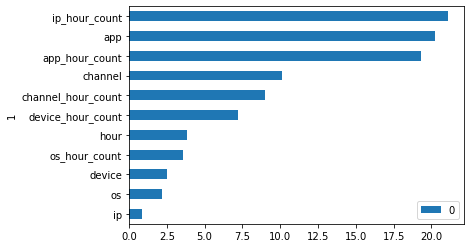

In [13]:
imp = pd.DataFrame(list(zip(model.get_feature_importance(),np.asarray(cat_features+num_features)))).set_index(1)
imp.sort_values(0, ascending=True).plot.barh()

## Prediction for test dataset

In [14]:
# Train model on full train data
# Hint! Use test data as eval_set to help catboost to calculate some count statistics for categorical fetures

train_pool = Pool(train_df[cat_features+num_features], train_df[target], feature_names=cat_features+num_features)
test_pool = Pool(test_df[cat_features+num_features], feature_names=cat_features+num_features)
model = CatBoostClassifier(iterations=1000, depth=6, loss_function='Logloss', learning_rate=0.03,
                           random_seed=42, verbose=100, metric_period=10, task_type='GPU', scale_pos_weight=1./train_df.is_attributed.mean())
model.fit(train_pool, eval_set=test_pool)

0:	learn: 0.6568451	total: 459ms	remaining: 7m 38s
100:	learn: 0.2234272	total: 47s	remaining: 6m 58s
200:	learn: 0.2094389	total: 1m 33s	remaining: 6m 10s
300:	learn: 0.2032125	total: 2m 19s	remaining: 5m 22s
400:	learn: 0.1995843	total: 3m 4s	remaining: 4m 36s
500:	learn: 0.1971306	total: 3m 50s	remaining: 3m 49s
600:	learn: 0.1953236	total: 4m 37s	remaining: 3m 3s
700:	learn: 0.1939039	total: 5m 23s	remaining: 2m 17s
800:	learn: 0.1926985	total: 6m 9s	remaining: 1m 31s
900:	learn: 0.1916565	total: 6m 55s	remaining: 45.7s
999:	learn: 0.1908689	total: 7m 41s	remaining: 0us


In [15]:
test_df['is_attributed'] = model.predict_proba(test_pool).T[1]

In [16]:
test_df[['click_id', 'is_attributed']].to_csv('../out/submission.csv.gz', index=False)
# 0.96545 on leaderboard